In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

In [3]:
# From Covid Tracking API
# https://covidtracking.com/api/
api_us = 'https://covidtracking.com/api/us/daily'
api_states = 'https://covidtracking.com/api/states/daily'

# https://github.com/COVID19Tracking/associated-data
f_pop = 'associated-data/us_census_data/us_census_2018_population_estimates_states.csv'

In [4]:
df_us = pd.read_json(api_us)
df_states = pd.read_json(api_states)
df_pop = pd.read_csv(f_pop)

In [5]:
df_us.shape

(32, 24)

In [6]:
df_states.shape

(1653, 25)

In [7]:
df_pop.head()

,state,state_name,geo_id,population,pop_density
0,AL,Alabama,1,4887871,96.509389
1,AK,Alaska,2,737438,1.291523
2,AZ,Arizona,4,7171646,63.135855
3,AR,Arkansas,5,3013825,57.919684
4,CA,California,6,39557045,253.906502


In [8]:
df_us['date'] = df_us['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
df_states['date'] = df_states['date'].apply(
    lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
df_us.sort_values(by=['date']).tail()

,date,states,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,death,hospitalized,total,totalTestResults,posNeg,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
4,2020-03-31,56,184683,864201,59518,14236.0,26660.0,3402.0,3644.0,69.0,...,3746,26660.0,1108402,1048884,1048884,807.0,4357.0,79877.0,24153.0,104030.0
3,2020-04-01,56,210816,939190,59669,16223.0,31142.0,3837.0,4270.0,71.0,...,4700,31142.0,1209675,1150006,1150006,954.0,4482.0,74989.0,26133.0,101122.0
2,2020-04-02,56,239099,1028649,62101,17157.0,32649.0,4264.0,541.0,67.0,...,5784,32649.0,1329849,1267748,1267748,1084.0,1507.0,89459.0,28283.0,117742.0
1,2020-04-03,56,271988,1135356,61980,19926.0,35991.0,4686.0,593.0,70.0,...,6962,35991.0,1469324,1407344,1407344,1178.0,3342.0,106707.0,32889.0,139596.0
0,2020-04-04,224,1223020,5272208,62292,88632.0,153608.0,20828.0,2764.0,2624.0,...,33256,153608.0,6557520,6495228,6495228,26294.0,117617.0,4136852.0,951032.0,5087884.0


In [10]:
df_states.sort_values(by=['date']).tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,hospitalized,total,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
32,2020-04-04,NE,321.0,5058.0,10.0,NaN,NaN,NaN,NaN,NaN,...,NaN,5389,5379,5379,31,0.0,0.0,571.0,42.0,613.0
31,2020-04-04,ND,186.0,6021.0,NaN,NaN,30.0,NaN,NaN,NaN,...,30.0,6207,6207,6207,38,0.0,1.0,396.0,13.0,409.0
30,2020-04-04,NC,2402.0,36371.0,NaN,271.0,259.0,NaN,NaN,NaN,...,259.0,38773,38773,38773,37,5.0,0.0,6866.0,309.0,7175.0
28,2020-04-04,MS,1455.0,5133.0,NaN,NaN,436.0,NaN,NaN,NaN,...,436.0,6588,6588,6588,28,6.0,16.0,380.0,97.0,477.0
0,2020-04-04,AK,171.0,5869.0,NaN,NaN,16.0,NaN,NaN,NaN,...,16.0,6040,6040,6040,2,2.0,1.0,10.0,14.0,24.0


In [11]:
# Merge in population data
df_states = pd.merge(df_states, df_pop, on='state')

# Calculate positive per million
df_states['pos_rate'] = df_states['positive'] / (df_states['population'] / 1e6)

# Calculate hospitalized per million
df_states['hosp_rate'] = df_states['hospitalized'] / (df_states['population'] / 1e6)

# Calculate deaths per million
df_states['death_rate'] = df_states['death'] / (df_states['population'] / 1e6)

# Calculate total tests
df_states['total'] = df_states['positive'] + df_states['negative']

# Calculate percent of tests that are positive
df_states['positive_rate'] = df_states['positive'] / df_states['total']

# Calculate tests per million people
df_states['test_rate'] = df_states['total'] / (df_states['population'] / 1e6)

# Calculate 7-day average deaths
df_states['death_7dma'] = df_states['death'].rolling(window=7).mean()

In [12]:
df_states.tail()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,state_name,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
1568,2020-03-11,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1569,2020-03-10,WY,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,0.0,NaN
1570,2020-03-09,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1571,2020-03-08,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN
1572,2020-03-07,WY,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Wyoming,56,577737,5.950611,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
df_states.describe()

,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,recovered,...,totalTestResultsIncrease,geo_id,population,pop_density,pos_rate,hosp_rate,death_rate,positive_rate,test_rate,death_7dma
count,1573.000000,1468.000000,446.000000,115.000000,449.000000,35.000000,64.000000,33.000000,43.000000,137.000000,...,1521.000000,1573.000000,1.573000e+03,1553.000000,1573.000000,449.000000,916.000000,1463.000000,1468.000000,608.000000
mean,1322.919263,6822.511580,1530.419283,1161.417391,589.512249,917.114286,332.218750,41.878788,115.093023,428.934307,...,1066.288626,29.534011,6.526141e+06,429.256019,151.989783,55.591045,5.498717,0.125868,1433.388732,39.669408
std,6558.510481,15253.364591,8807.411069,3087.142436,2492.617281,1221.286105,674.570915,100.434916,159.566200,1544.786708,...,3085.420841,16.322478,7.358269e+06,1600.482538,414.944812,131.028224,13.502891,0.140942,2105.964388,141.920116
min,0.000000,0.000000,-3.000000,2.000000,0.000000,9.000000,6.000000,4.000000,4.000000,2.000000,...,-585.000000,1.000000,5.777370e+05,1.291523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,121.750000,4.000000,37.000000,24.000000,19.000000,12.750000,6.000000,9.500000,24.000000,...,17.000000,16.000000,1.805832e+06,54.955978,2.534738,10.876164,0.343465,0.045775,38.448144,2.571429
50%,95.000000,1227.000000,22.000000,72.000000,91.000000,410.000000,60.000000,21.000000,39.000000,38.000000,...,156.000000,29.000000,4.468402e+06,107.860112,28.233151,25.849297,1.595001,0.083475,426.545908,8.714286
75%,552.000000,6361.000000,118.000000,400.000000,289.000000,1436.500000,205.500000,37.000000,135.500000,94.000000,...,932.000000,42.000000,7.535591e+06,229.511156,144.967782,48.423236,4.706746,0.153176,2168.683163,25.821429
max,113704.000000,169917.000000,64400.000000,15905.000000,26383.000000,4126.000000,3022.000000,571.000000,535.000000,10478.000000,...,78400.000000,72.000000,3.955704e+07,11490.119540,5818.380102,1350.052085,182.425641,0.891705,14513.251803,2078.142857


## California

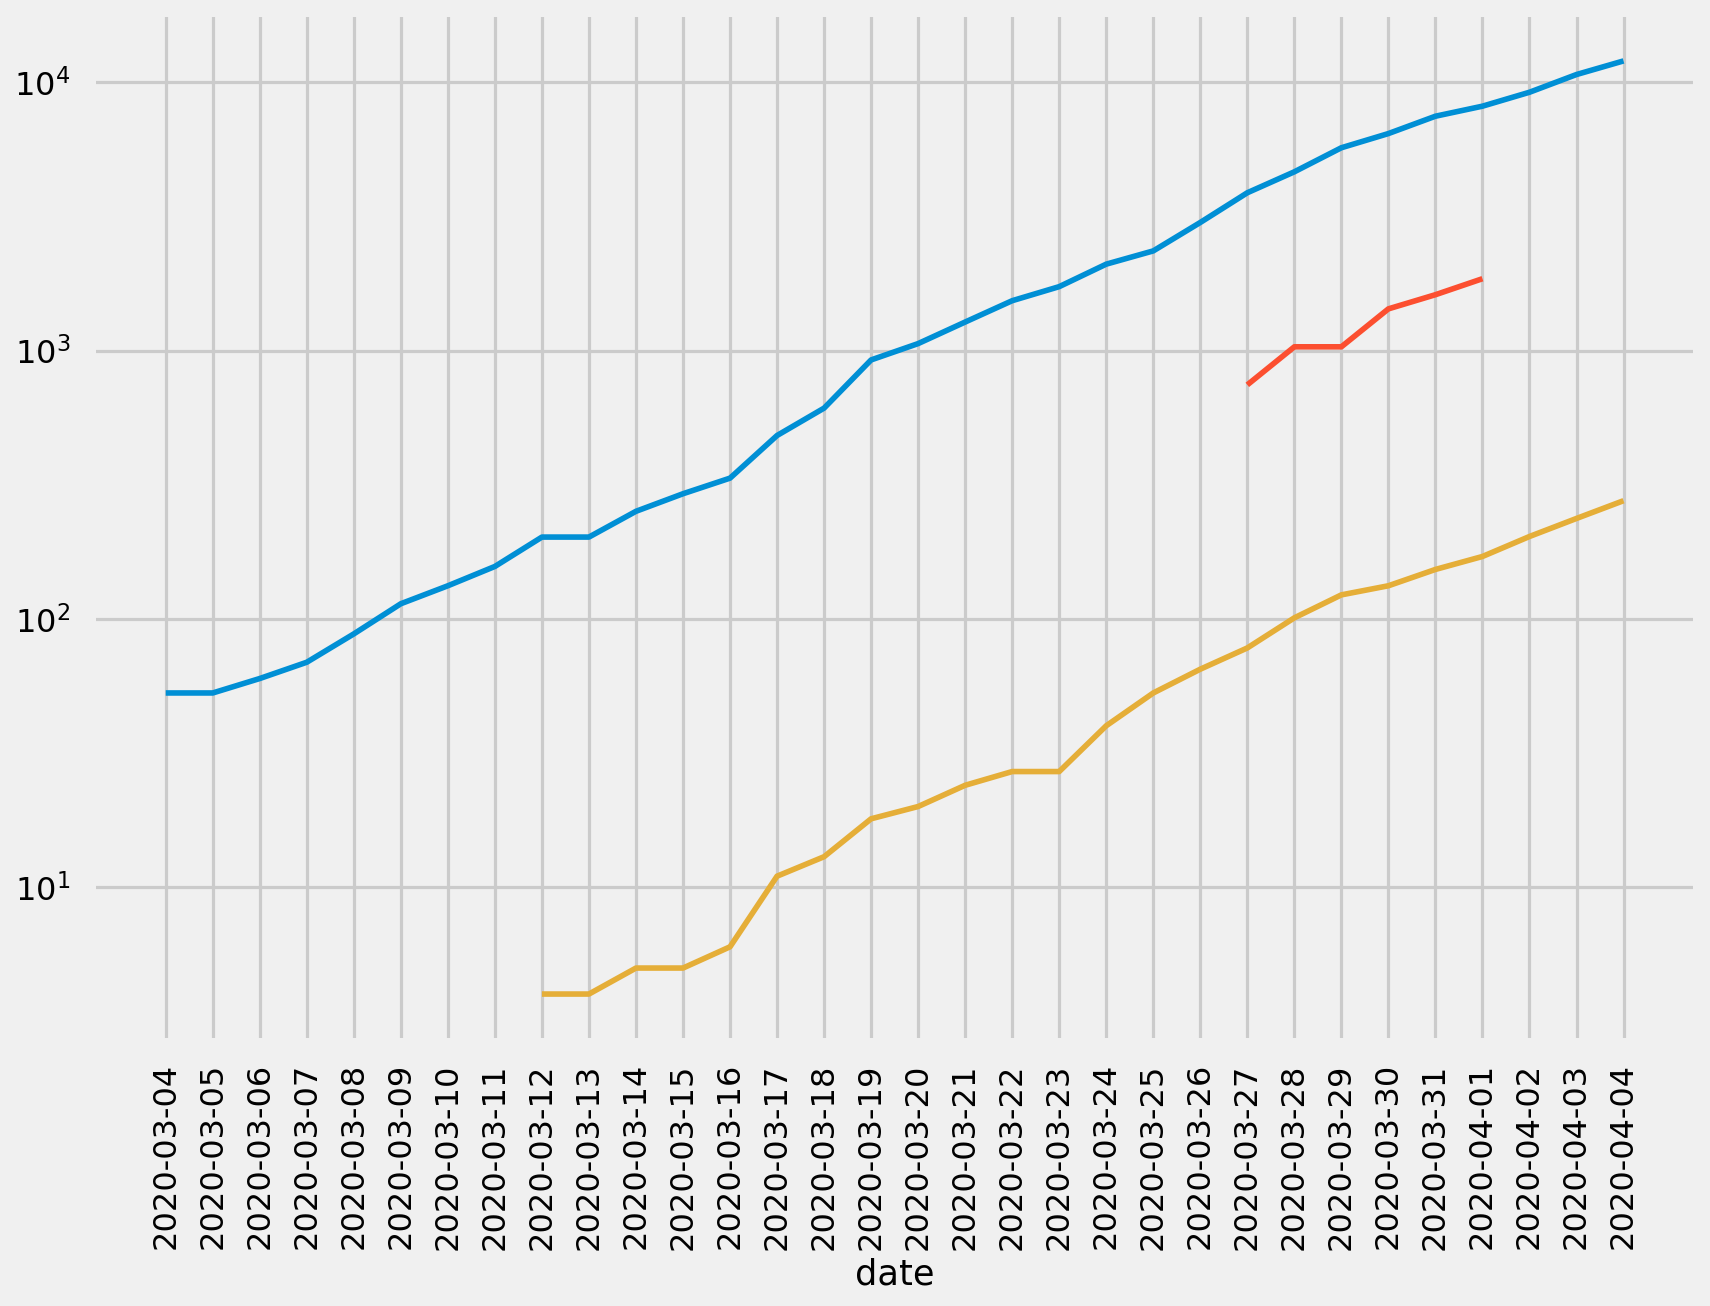

In [14]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "CA"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "CA"'))
ax.set(xticks=df_states.query('state == "CA"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

## New York

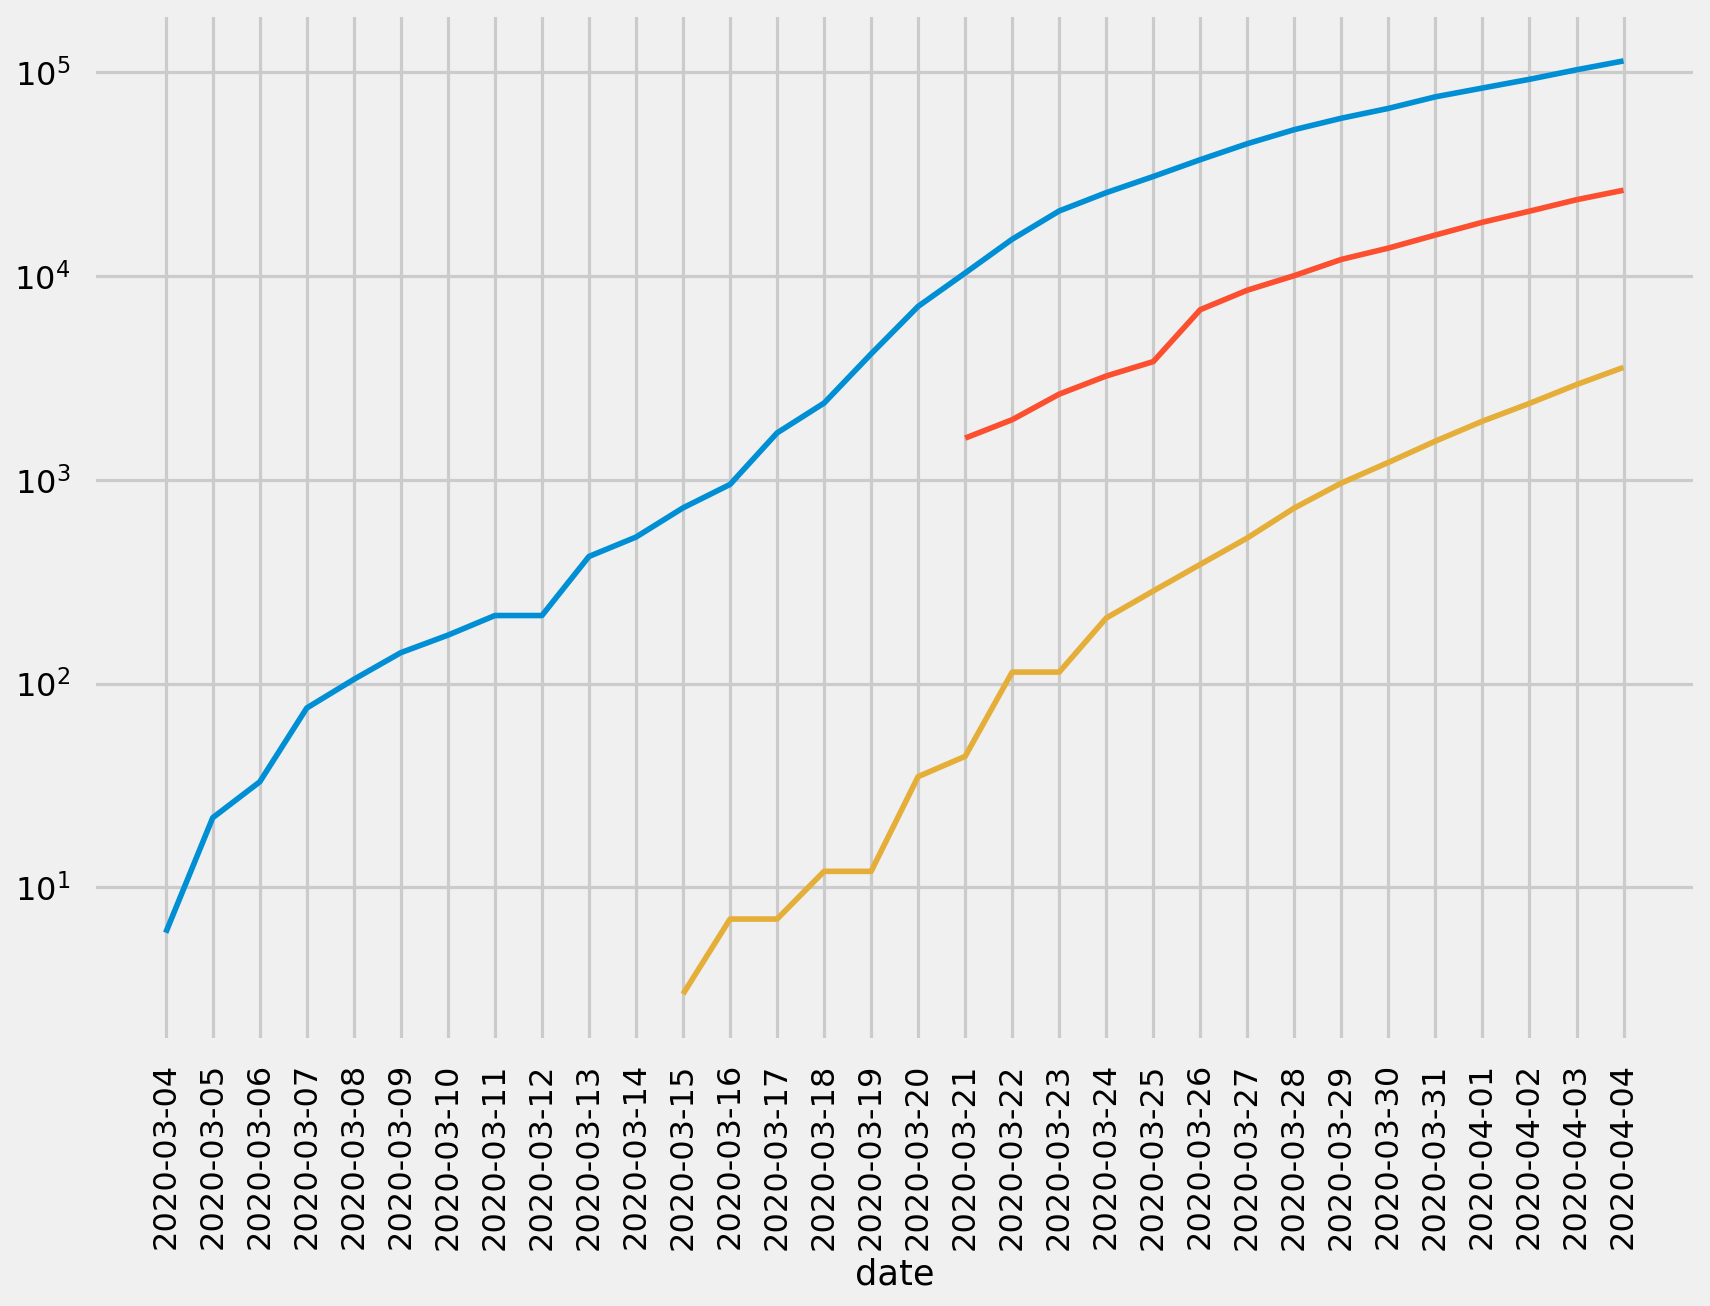

In [15]:
ax = sns.lineplot(x="date", y="positive", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="hospitalized", 
                  data=df_states.query('state == "NY"'))
ax = sns.lineplot(x="date", y="death", 
                  data=df_states.query('state == "NY"'))
ax.set(xticks=df_states.query('state == "NY"').date.values)
plt.xticks(rotation=90)
ax.set_ylabel('')
ax.set_yscale('log')
plt.show()

# Top 10 States by Deaths

In [16]:
latest_date = df_states['date'].max()
top_states = df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False).state.head(10).tolist()
df_top_states = df_states.query('state == @top_states')
top_states

['NY', 'NJ', 'MI', 'LA', 'WA', 'CA', 'IL', 'MA', 'GA', 'FL']

In [17]:
df_states.query('date == @latest_date').sort_values(by='death', 
                                                    ascending=False)[['state', 'death']]

,state,death
1033,NY,3565.0
941,NJ,846.0
669,MI,540.0
548,LA,409.0
1450,WA,284.0
121,CA,276.0
426,IL,243.0
577,MA,216.0
306,GA,201.0
274,FL,191.0


In [18]:
# Deaths per million people
df_states.query('date == @latest_date').sort_values(by='death_rate', 
                                                    ascending=False)[['state', 'death_rate']]

,state,death_rate
1033,NY,182.425641
941,NJ,94.965269
548,LA,87.768655
669,MI,54.022068
184,CT,46.184011
1450,WA,37.687820
1420,VT,31.933629
577,MA,31.294601
213,DC,29.895153
153,CO,19.488851


# Deaths

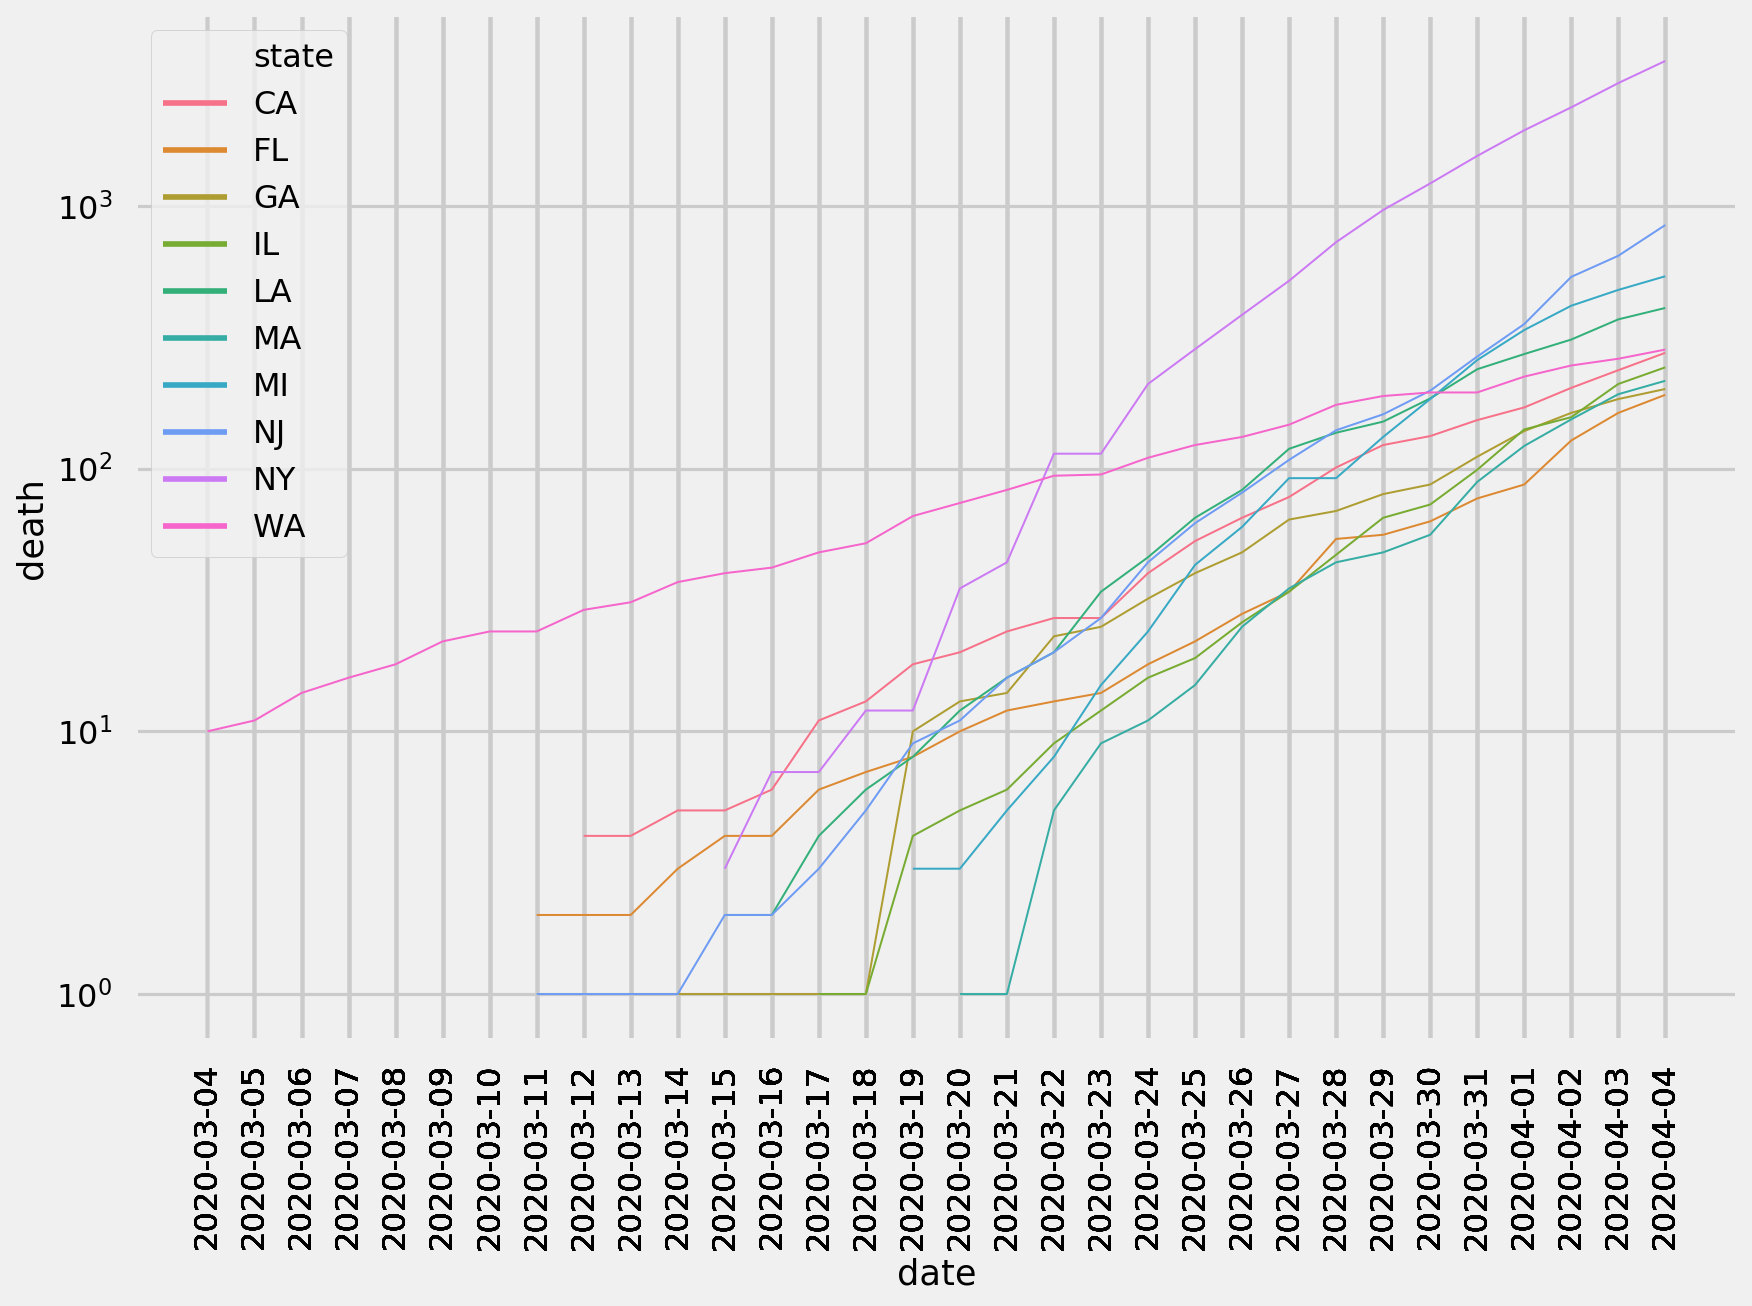

In [19]:
ax = sns.lineplot(x="date", 
                  y="death", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths (7-day Moving Average)

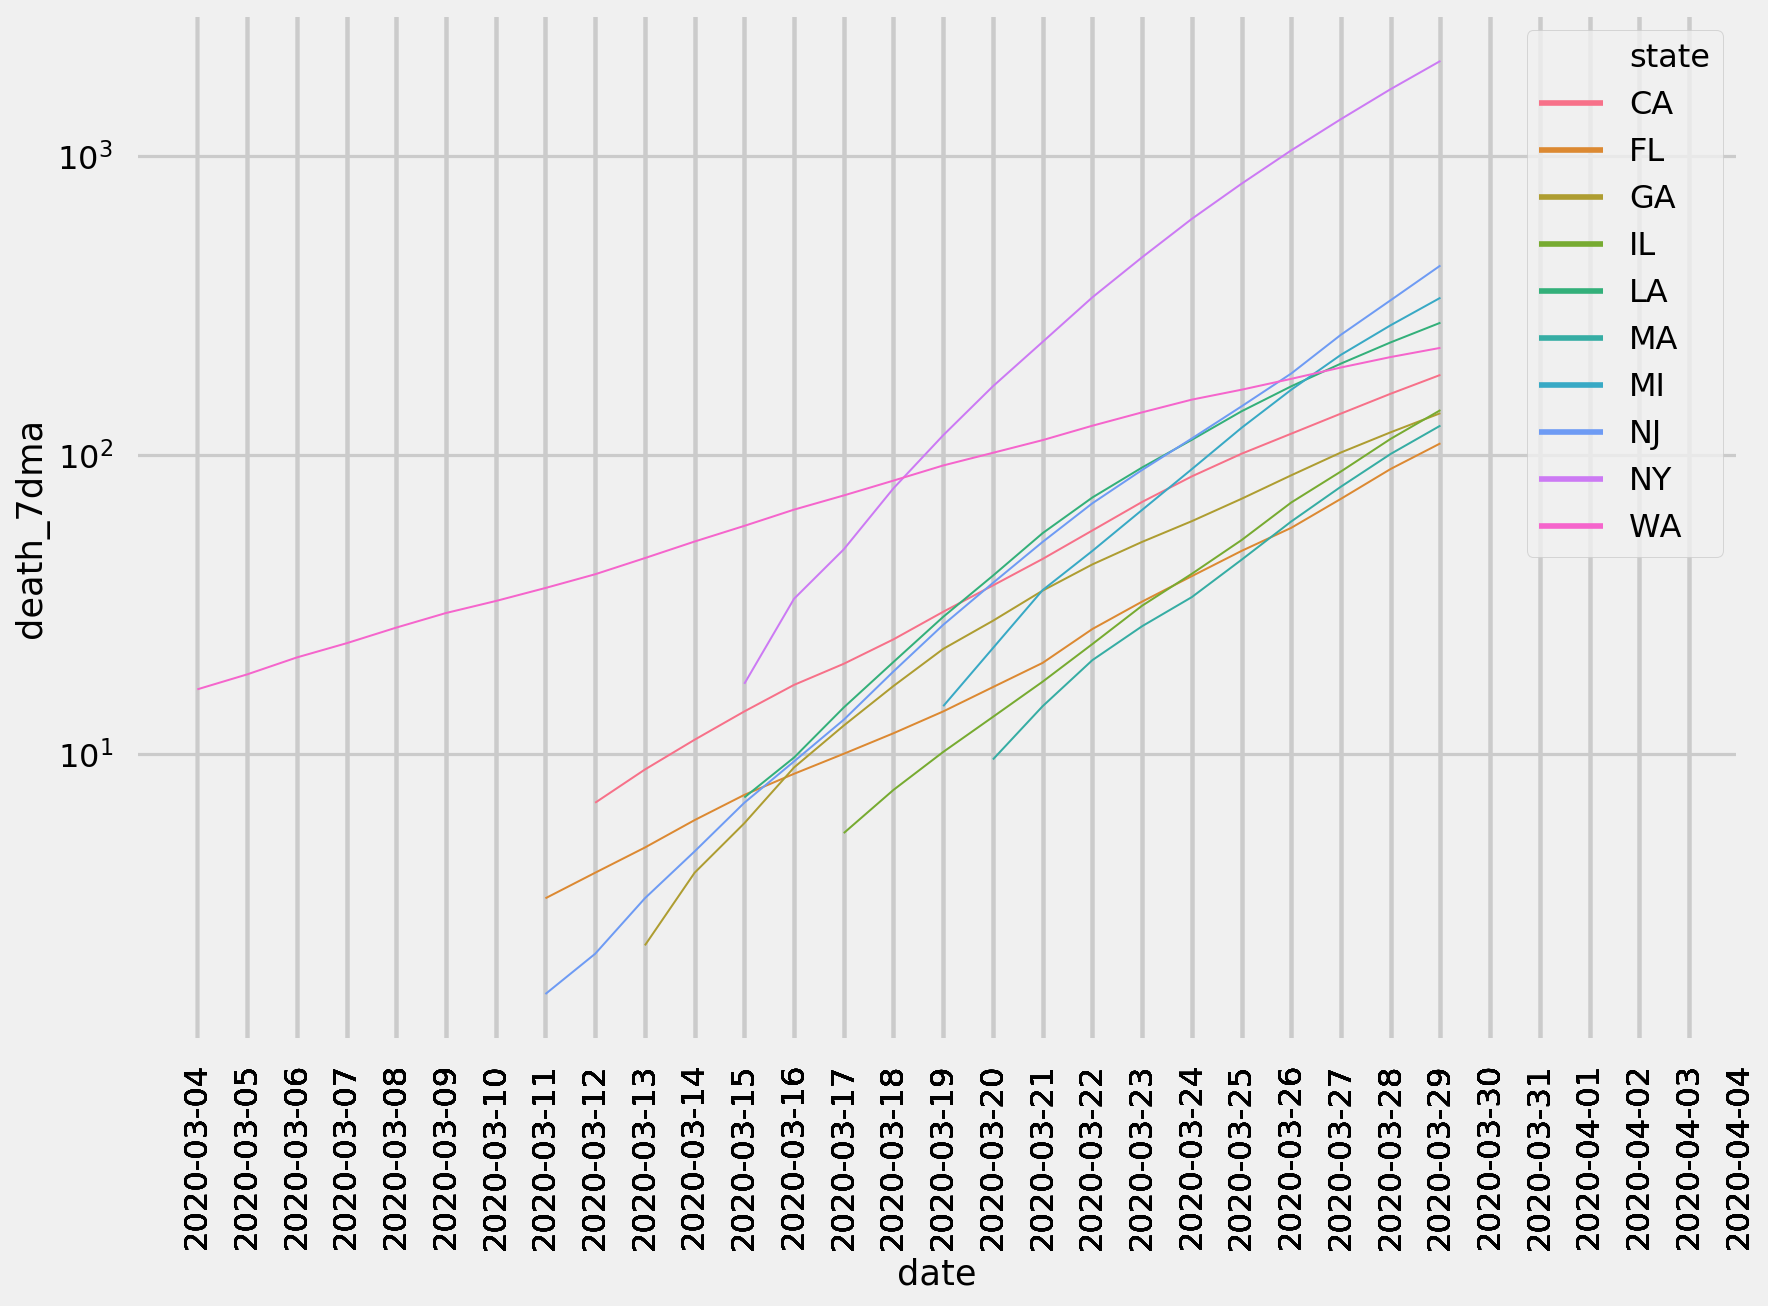

In [20]:
# TODO: index this by date first crossed 5 deaths
ax = sns.lineplot(x="date", 
                  y="death_7dma", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Positive Cases Per Million People

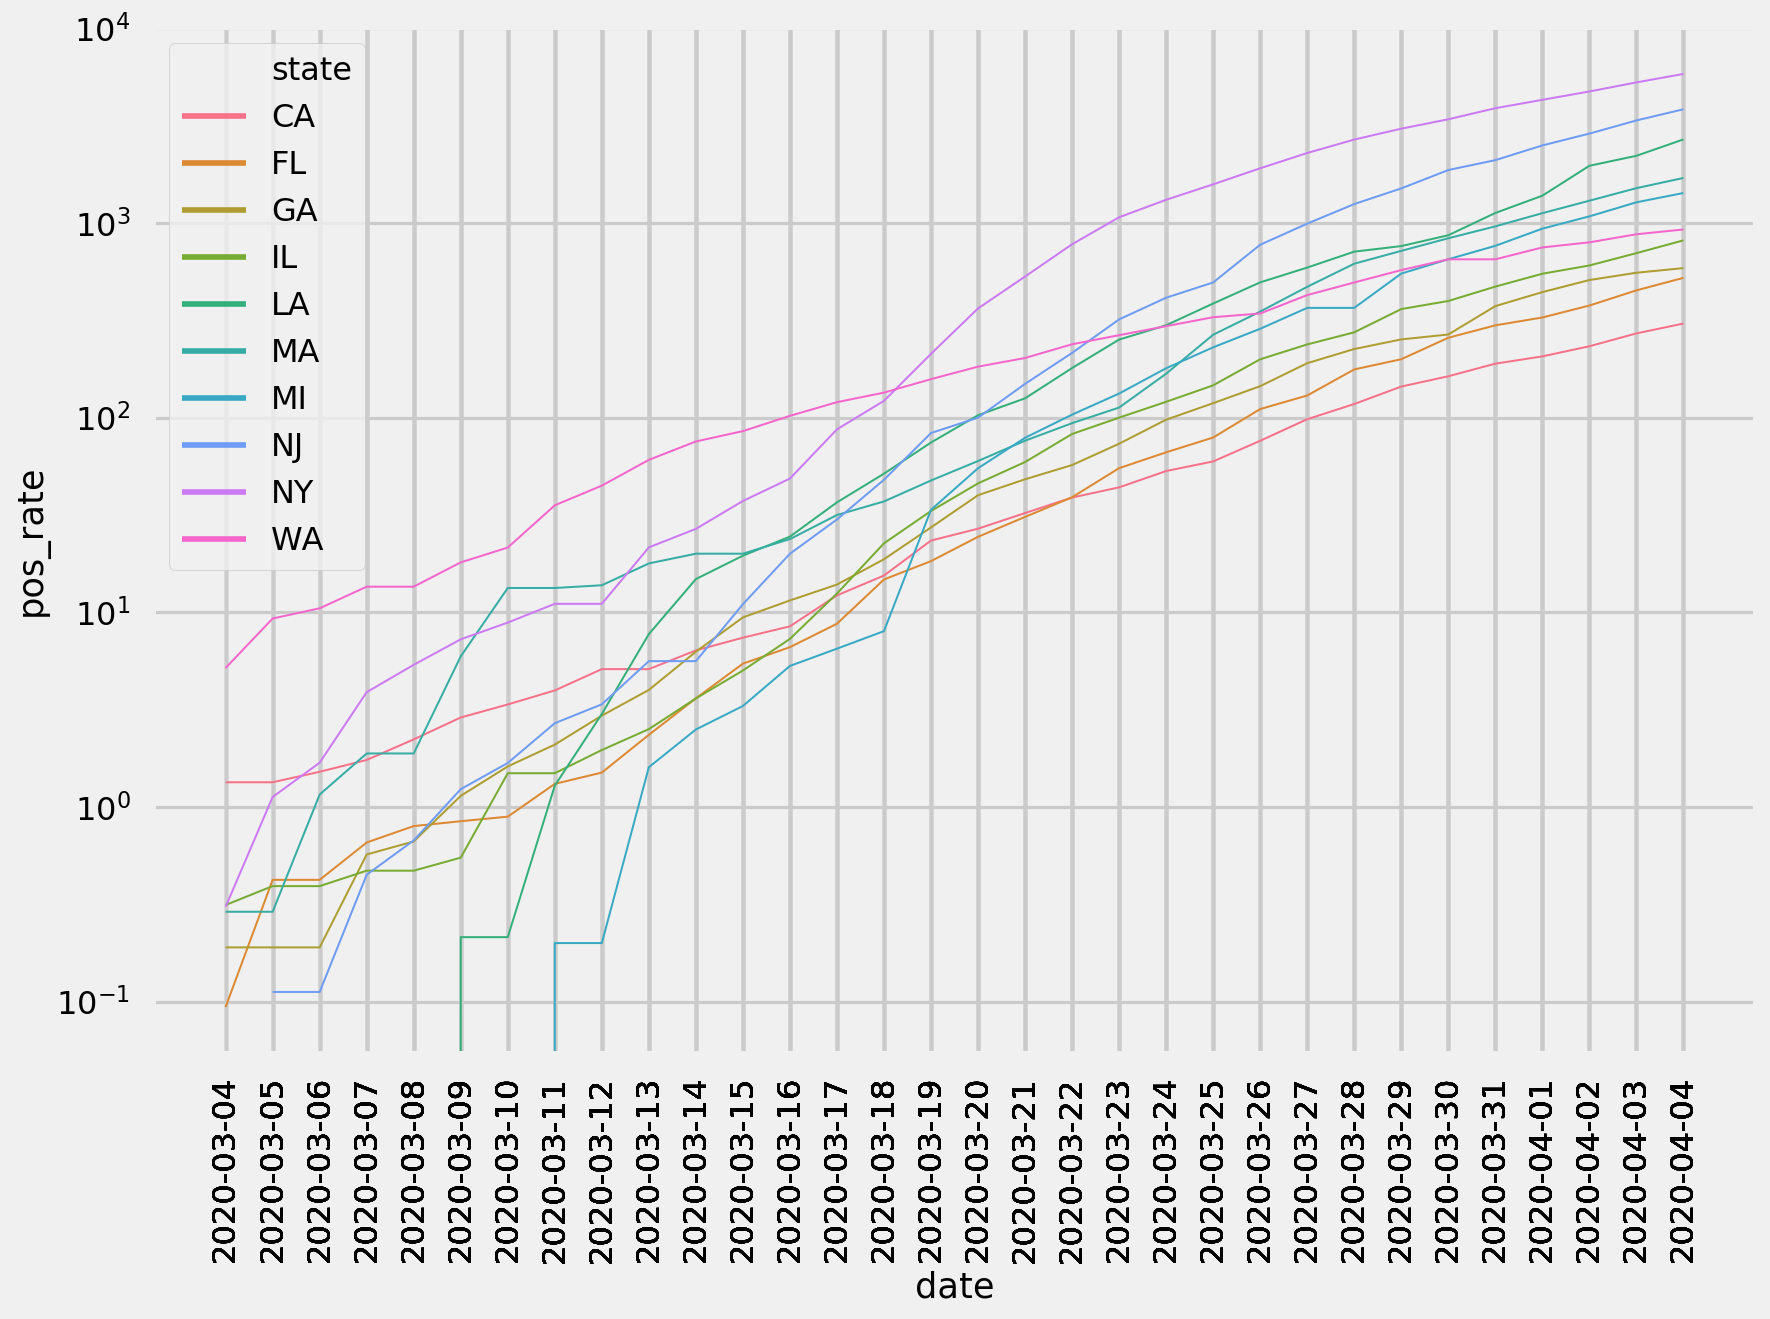

In [21]:
ax = sns.lineplot(x="date", y="pos_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Hospitalized Per Million People

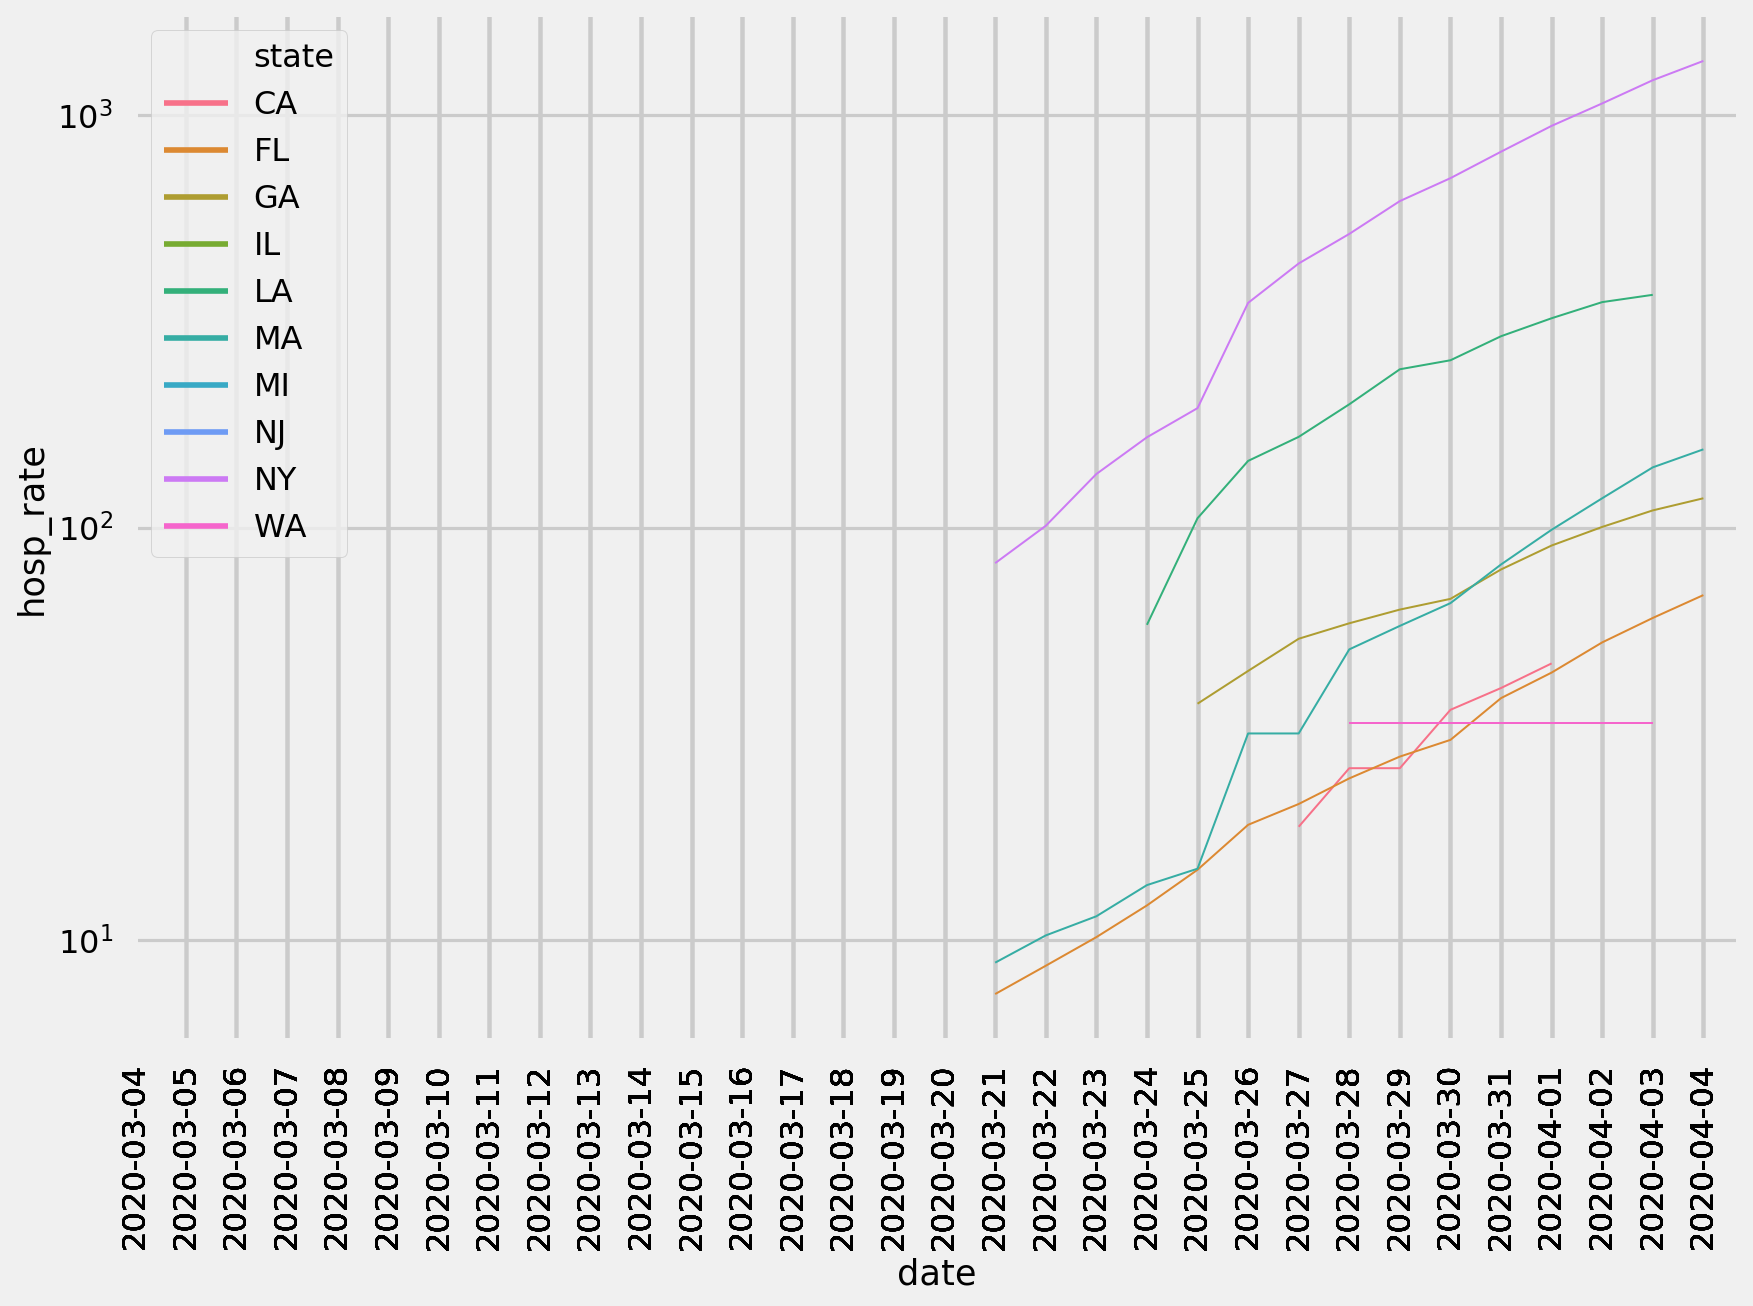

In [22]:
ax = sns.lineplot(x="date", y="hosp_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Deaths Per Million People

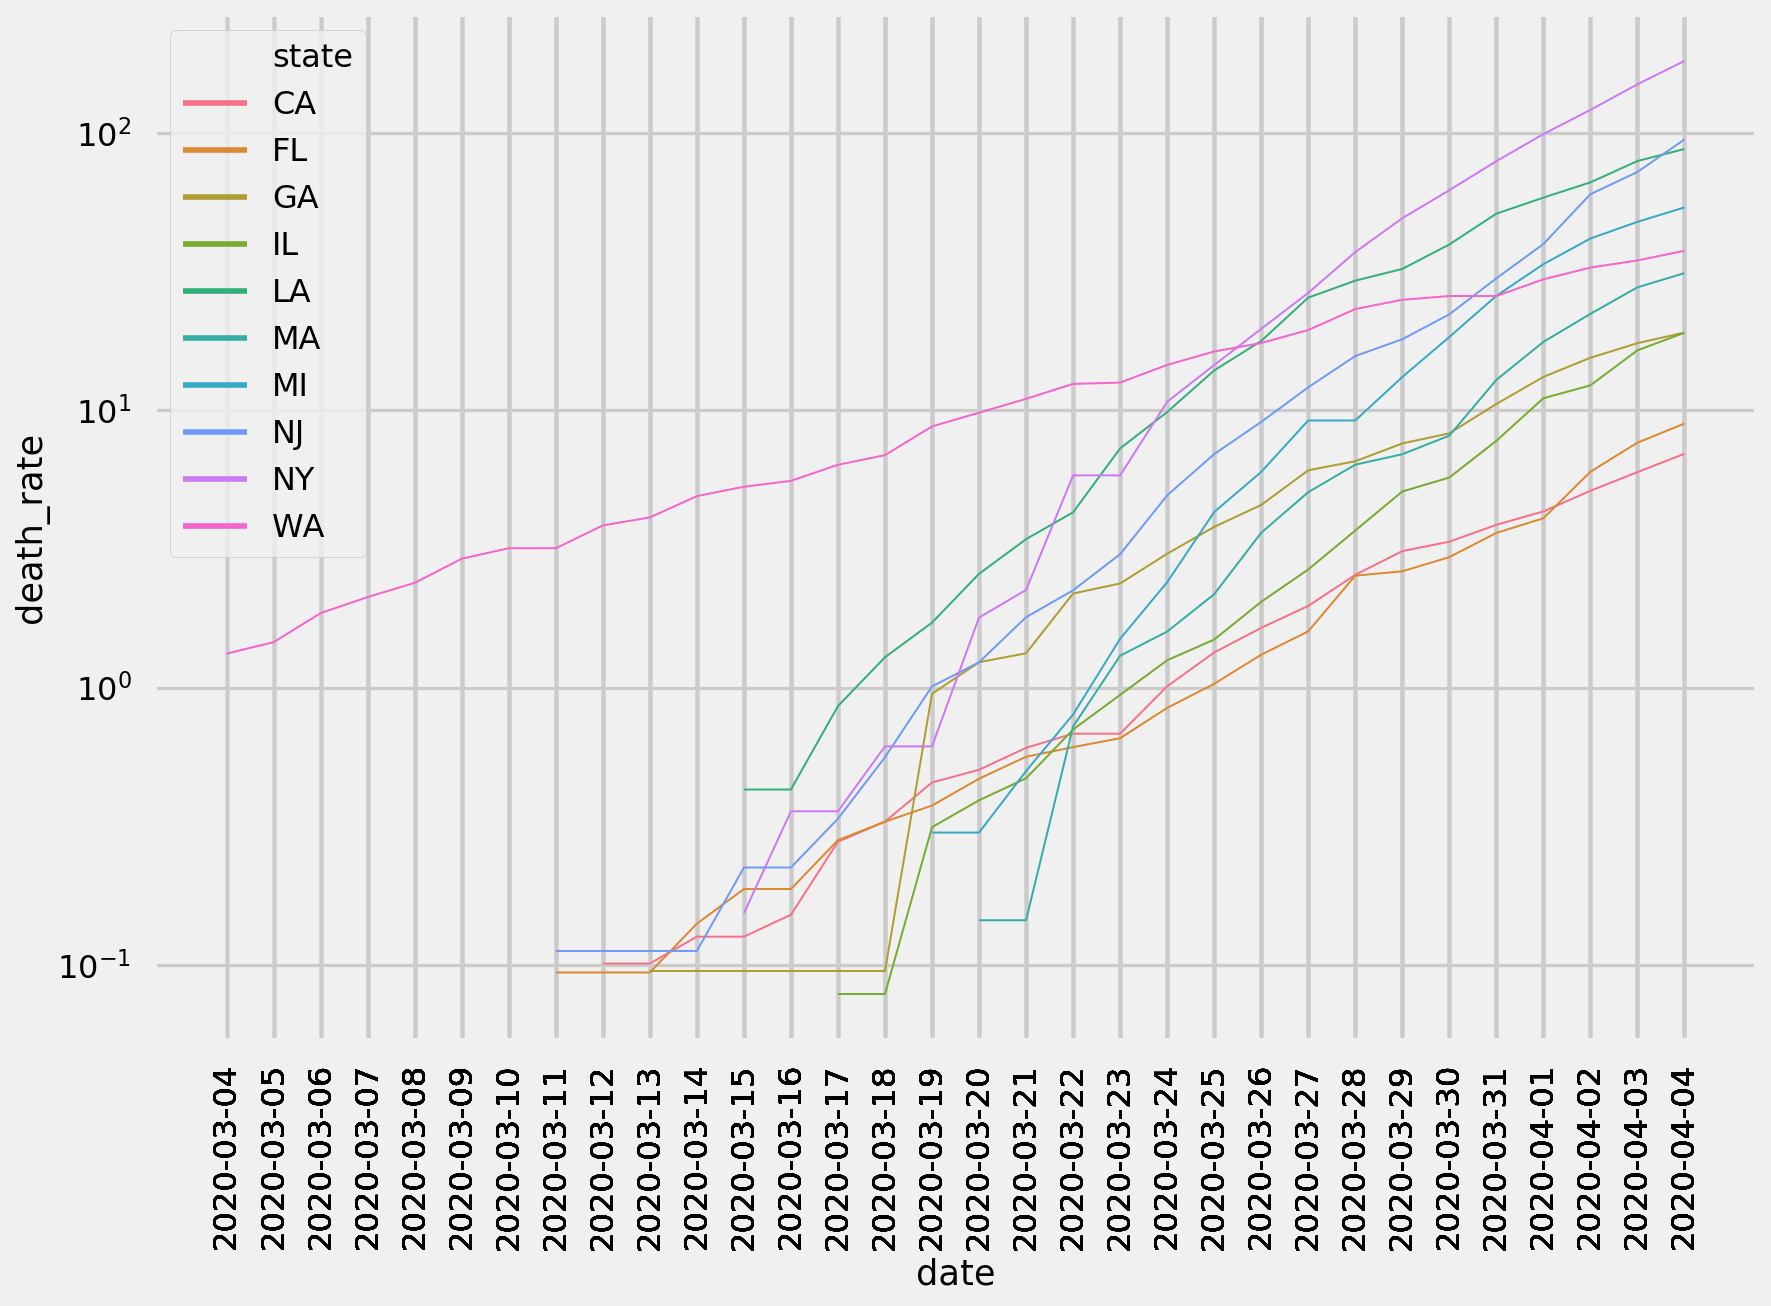

In [23]:
ax = sns.lineplot(x="date", y="death_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

# Tests Per Million People

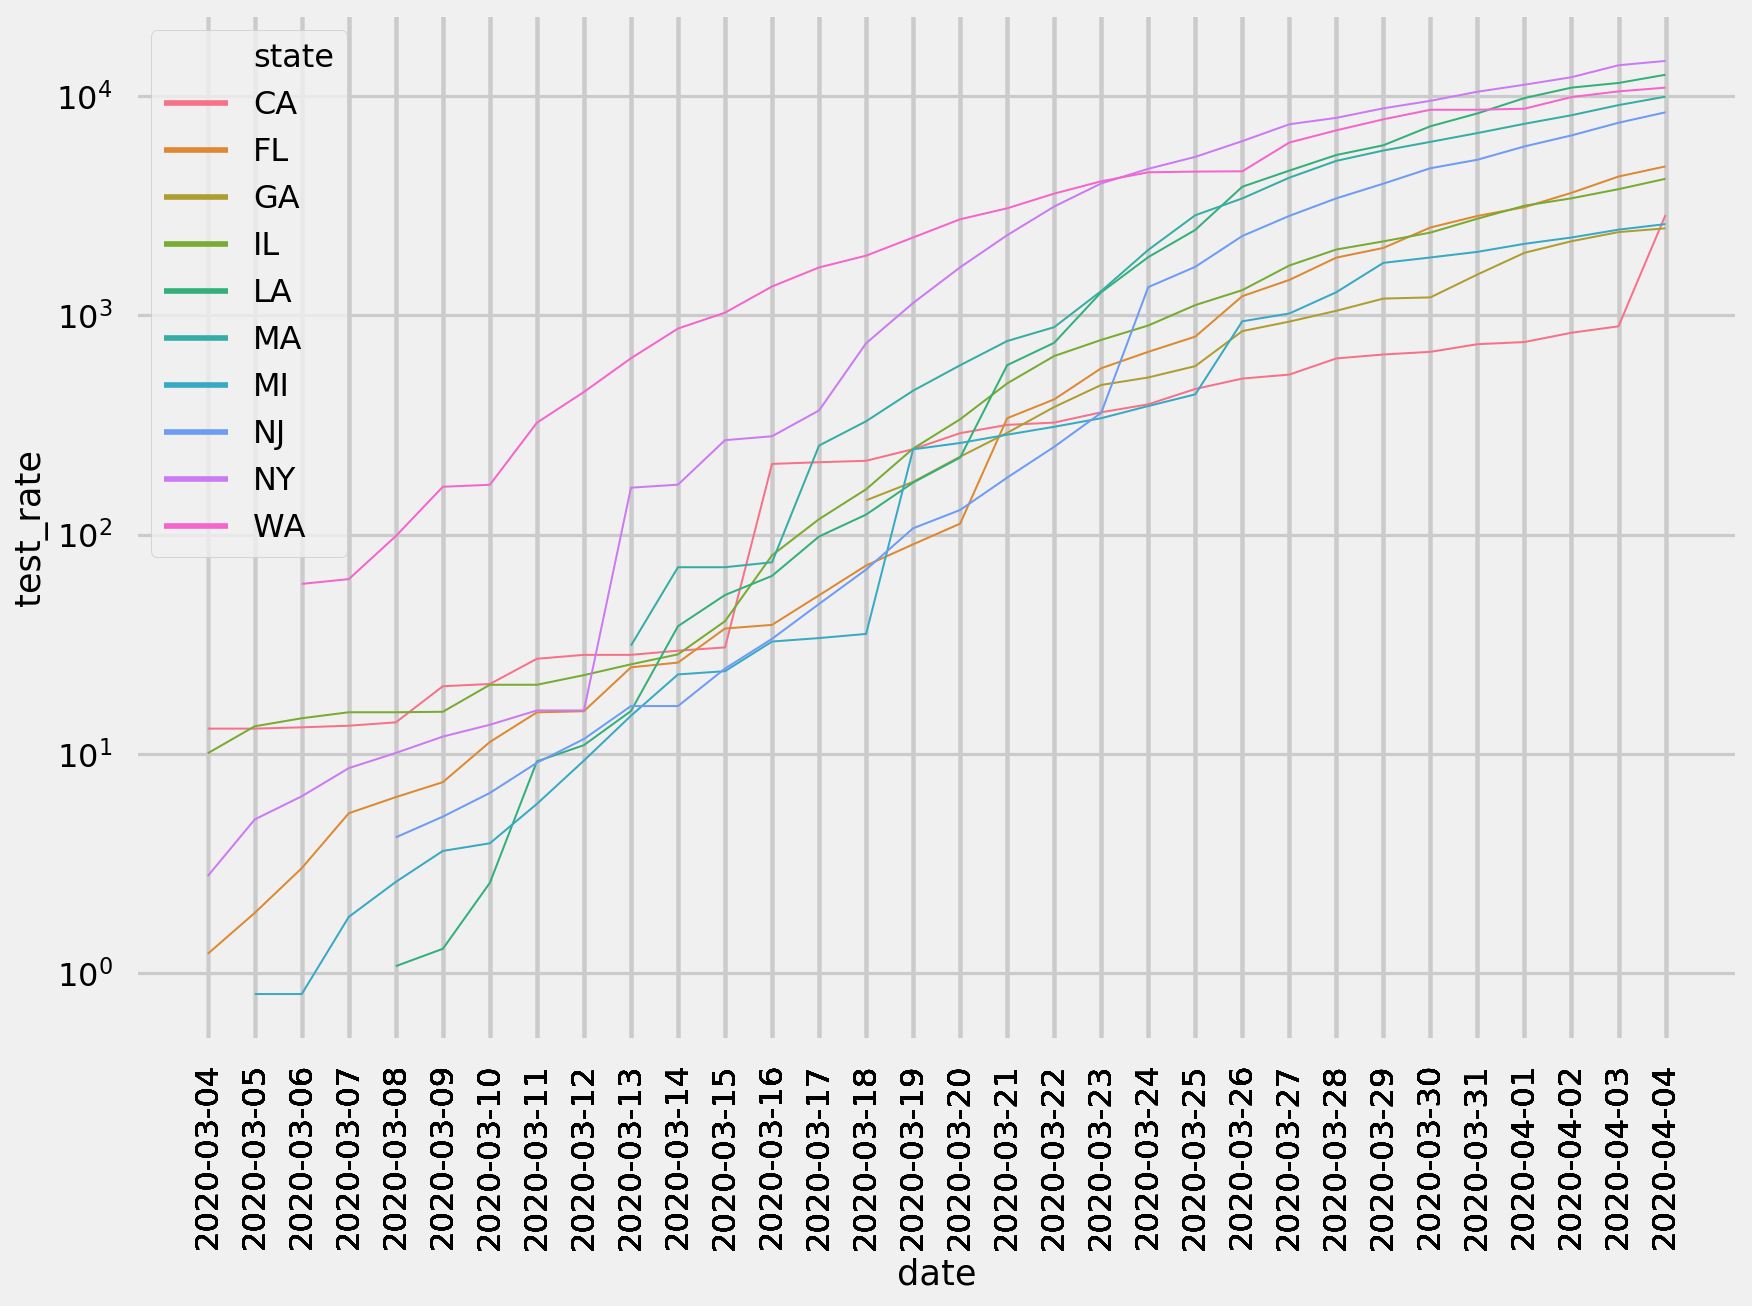

In [24]:
ax = sns.lineplot(x="date", y="test_rate", 
                  hue="state",
                  estimator=None, 
                  lw=1,
                  data=df_top_states)
ax.set(xticks=df_top_states.date.values)
ax.set_yscale('log')
plt.xticks(rotation=90)
plt.show()

In [25]:
df_states.query('date == @latest_date').sort_values(by='test_rate', 
                                                    ascending=False)[['state', 'test_rate']]

,state,test_rate
1033,NY,14513.251803
548,LA,12553.278149
1450,WA,10961.184066
577,MA,9967.909994
1420,VT,9331.006436
213,DC,9164.999893
1360,UT,8871.264953
338,HI,8643.490173
941,NJ,8458.868589
0,AK,8190.519067
